# Exploratory Data Analysis

This notebook performs an initial EDA based on the sample data extracted during the data pull and etl steps.

In [1]:
import os
from os.path import join
from sqlite3 import connect
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

project_dir = join(os.getcwd(), os.pardir)
raw_dir = join(project_dir, 'data', 'raw')
interim_dir = join(project_dir, 'data', 'interim')
db_name = 'data_pull_sample.db'

%config InlineBackend.figure_format = 'svg'

In [2]:
conn = connect(join(interim_dir, db_name))
df_users = pd.read_sql('SELECT * FROM users ', conn)
df_tweets = pd.read_sql('SELECT * FROM tweets', conn)

df_twt = df_tweets.drop_duplicates(subset='id_str')
df_twt = df_twt.merge(df_users, left_on='user_id_str', right_on='id_str', how='left', suffixes=('_tweets', '_users'))
df_twt.loc[:,'is_original'] = ~df_twt[['is_reply', 'is_retweet', 'is_quote_status']].sum(1).astype(bool)

## EDA Questions:
- How many tweets are in the dataset?
- How many unique tweets are in the dataset?
- How many unique users?
- Number of retweets
- Locate the top N retweeted and liked tweets and the users that posted them
- What are the locations? (Number of tweets by location)
- What are the main languages? What are the counts and proportions of tweets by languages?
- Location over time
- Source analysis
- Protected
- Verified

___
## Tweet Analysis
### How many tweets are in the dataset? How many unique tweets are in the dataset? Number of retweets?

In [3]:
print(f"""
Total number of Tweets:\t\t{df_twt.shape[0]}
Number of original Tweets:\t{df_twt.is_original.sum()}
Number of retweets:\t\t{df_twt.is_retweet.sum()}
Number of replies:\t\t{df_twt.is_reply.sum()}
Number of quotes:\t\t{df_twt.is_quote_status.sum()}

Note: Many of the quote statuses/tweets are both marked as quotes and retweets.
""")


Total number of Tweets:		20500
Number of original Tweets:	4011
Number of retweets:		15022
Number of replies:		1197
Number of quotes:		1317

Note: Many of the quote statuses/tweets are both marked as quotes and retweets.



### Locate the top N retweeted and liked tweets and the users that posted them

In [4]:
N = 20
df_twt[df_twt.is_original==True]\
    .nlargest(N, 'retweet_count')\
    [['id_str_tweets', 'full_text', 'retweet_count', 'name']]

,id_str_tweets,full_text,retweet_count,name
15807,1270295836342120448,I offer my tributes to the people who have los...,866,Amit Shah
4978,1271384518096642048,Happy that we're supporting 10K families from ...,687,Manu Kumar Jain
20480,1269958731858685952,ओड़िशा में अभी अम्फान चक्रवात आया तब अपनी जान ...,494,BJP
19357,1270036860371267584,50 NDRF personnel who worked during cyclone Am...,486,Press Trust of India
17275,1270234333178138624,I want to pay my tributes to the people who ha...,383,BJP
8947,1271051775093567488,An initiative to join hands with 1 lakh youth ...,259,Partha Chatterjee
1875,1271837702602674176,Since there's no upcoming election in Maharash...,223,Maharashtra Congress
10440,1271026495582908416,WB is currently battling multiple challenges l...,222,Citizen Madan Mitra| নাগরিক মদন মিত্র
10868,1270986858797785088,"We shall overcome\nআমরা করব জয়\n\n#KKR, @Meer...",218,KolkataKnightRiders
9841,1271040357090816000,Fighting COVID-19 and post-Amphan devastation ...,206,Rathin Ghosh


### What are the locations? (Number of tweets by location)

In [5]:
no_loc_count = df_twt.derived__location.isnull().sum()
print(f"""Please note that {no_loc_count} tweets (~{int(no_loc_count/df_twt.shape[0]*100)}% \
of the dataset) do not contain location info.""")

top_locations = df_twt.groupby('derived__location')\
    .size()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0:'Count', 'derived__location':'Country'})\
    .set_index('Country')\
    .nlargest(20, 'Count')

top_locations

Please note that 10186 tweets (~49% of the dataset) do not contain location info.


,Count
Country,
India,9109
United States,247
Bangladesh,135
United Kingdom,126
Equatorial Guinea,120
Sri Lanka,55
Japan,39
Thailand,35
Australia,30


### What are the main languages? What are the counts and proportions of tweets by languages?

In [6]:
no_loc_count = df_twt.lang.isnull().sum()
print(f"""Please note that {no_loc_count} tweets (~{int(no_loc_count/df_twt.shape[0]*100)}% \
of the dataset) do not contain tweet language info.""")

df_twt.groupby('lang')\
    .size()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0:'Count', 'lang':'Language'})\
    .set_index('Language')\
    .nlargest(20, 'Count')

Please note that 0 tweets (~0% of the dataset) do not contain tweet language info.


,Count
Language,
en,16259
hi,1293
bn,1112
und,814
ja,475
mr,270
in,126
tl,22
kn,17


### Source analysis

In [7]:
no_loc_count = df_twt.source.isnull().sum()
print(f"""Please note that {no_loc_count} tweets (~{int(no_loc_count/df_twt.shape[0]*100)}% \
of the dataset) do not contain source info.""")

main_sources = {
    '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>': 'Android',
    '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>': 'Web',
    '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>': 'Web',
    '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone',
    '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>': 'iPad',
}

df_twt['main_sources'] = df_twt['source'].apply(
    lambda x: main_sources[x] 
    if x in main_sources.keys() 
    else 'Others/Unknown'
)

df_twt.groupby('main_sources')\
    .size()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0:'Count', 'main_sources':'Source'})\
    .set_index('Source')\
    .nlargest(20, 'Count')

Please note that 0 tweets (~0% of the dataset) do not contain source info.


,Count
Source,
Android,13905
Web,2803
Others/Unknown,1942
iPhone,1766
iPad,84


### Location over time

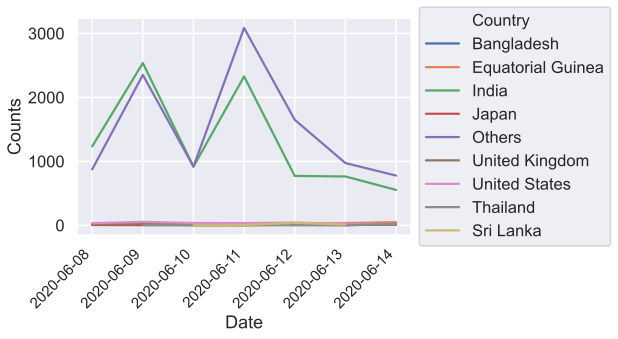

In [8]:
pd.options.mode.chained_assignment = None

top_locations_list = top_locations.iloc[:8]\
    .index.tolist()

df_places = df_twt[['created_at_tweets', 'derived__location']]
df_places.loc[:,'created_at'] = pd.to_datetime(df_places.created_at_tweets).dt.date
df_places.loc[:,'derived__location'] = df_places.derived__location.apply(
    lambda x: x 
    if x in top_locations_list
    else 'Others'
)

df_places = df_places\
    .drop(columns='created_at_tweets')\
    .groupby(['created_at', 'derived__location']).size()\
    .to_frame().reset_index()\
    .rename(columns={0:'Counts', 'derived__location':'Country', 'created_at': 'Date'})\
    .sort_index()

sns.set(style="darkgrid", context="talk")
sns.lineplot(
    data=df_places, hue='Country', x='Date', y='Counts'
).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)


plt.show()

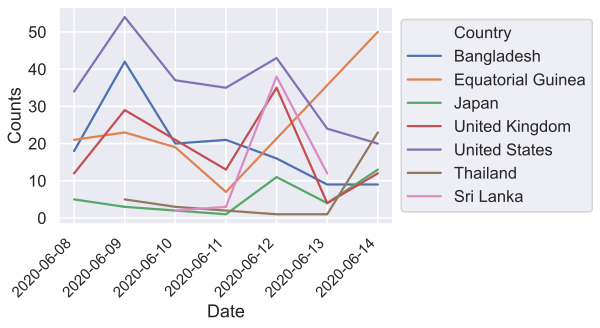

In [9]:
pd.options.mode.chained_assignment = None

top_locations_list = top_locations.iloc[:8]\
    .index.tolist()

df_places = df_twt[['created_at_tweets', 'derived__location']]
df_places.loc[:,'created_at'] = pd.to_datetime(df_places.created_at_tweets).dt.date
df_places.loc[:,'derived__location'] = df_places.derived__location.apply(
    lambda x: x 
    if x in top_locations_list
    else 'Others'
)

df_places = df_places[~df_places['derived__location'].isin(['Others', 'India'])]

df_places = df_places\
    .drop(columns='created_at_tweets')\
    .groupby(['created_at', 'derived__location']).size()\
    .to_frame().reset_index()\
    .rename(columns={0:'Counts', 'derived__location':'Country', 'created_at': 'Date'})\
    .sort_index()

sns.set(style="darkgrid", context="talk")
sns.lineplot(
    data=df_places, hue='Country', x='Date', y='Counts'
).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)


plt.show()

___
## User Analysis
### How many unique users? Verified and Protected Users Analysis

In [10]:
print(f"""
Number of unique users: {df_users.drop_duplicates(subset='id_str').shape[0]}
Number of verified users: {df_users.verified.sum()}
Number of protected users: {df_users.protected.sum()}
""")


Number of unique users: 11358
Number of verified users: 329
Number of protected users: 0

